In [44]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
# Load dataset
df = pd.read_csv("mat_health.csv")  # Replace with your actual dataset file

# Handling missing values (optional, remove or impute missing values)
df = df.dropna()

# Encoding categorical features if needed
categorical_cols = ["Previous Complications", "Preexisting Diabetes", "Gestational Diabetes", "Mental Health", "Risk Level"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for decoding predictions later

# Define features and target
X = df.drop(columns=["Risk Level"])  # Features
y = df["Risk Level"]  # Target variable

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features (recommended for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





In [45]:
# Fit model
# Standardize and rewrap with column names
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use PermutationImportance
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)

# Show feature importances
eli5.show_weights(perm, feature_names=X.columns.tolist())




Weight,Feature
0.0709 ± 0.0327,Preexisting Diabetes
0.0632 ± 0.0322,Gestational Diabetes
0.0333 ± 0.0126,BMI
0.0197 ± 0.0042,Mental Health
0.0171 ± 0.0153,Heart Rate
0.0145 ± 0.0087,BS
0.0051 ± 0.0064,Diastolic
0.0051 ± 0.0064,Systolic BP
0.0043 ± 0.0000,Previous Complications
0.0017 ± 0.0042,Age


In [46]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

<!-- http://127.0.0.1:7001/13399971216/ -->

🔹 Logistic Regression Model
Accuracy: 0.9786
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        86
           1       0.99      0.98      0.98       148

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234

------------------------------------------------------------
🔹 Decision Tree Model
Accuracy: 0.9786
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        86
           1       0.97      0.99      0.98       148

    accuracy                           0.98       234
   macro avg       0.98      0.97      0.98       234
weighted avg       0.98      0.98      0.98       234

------------------------------------------------------------
🔹 Random Forest Model
Accuracy: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   

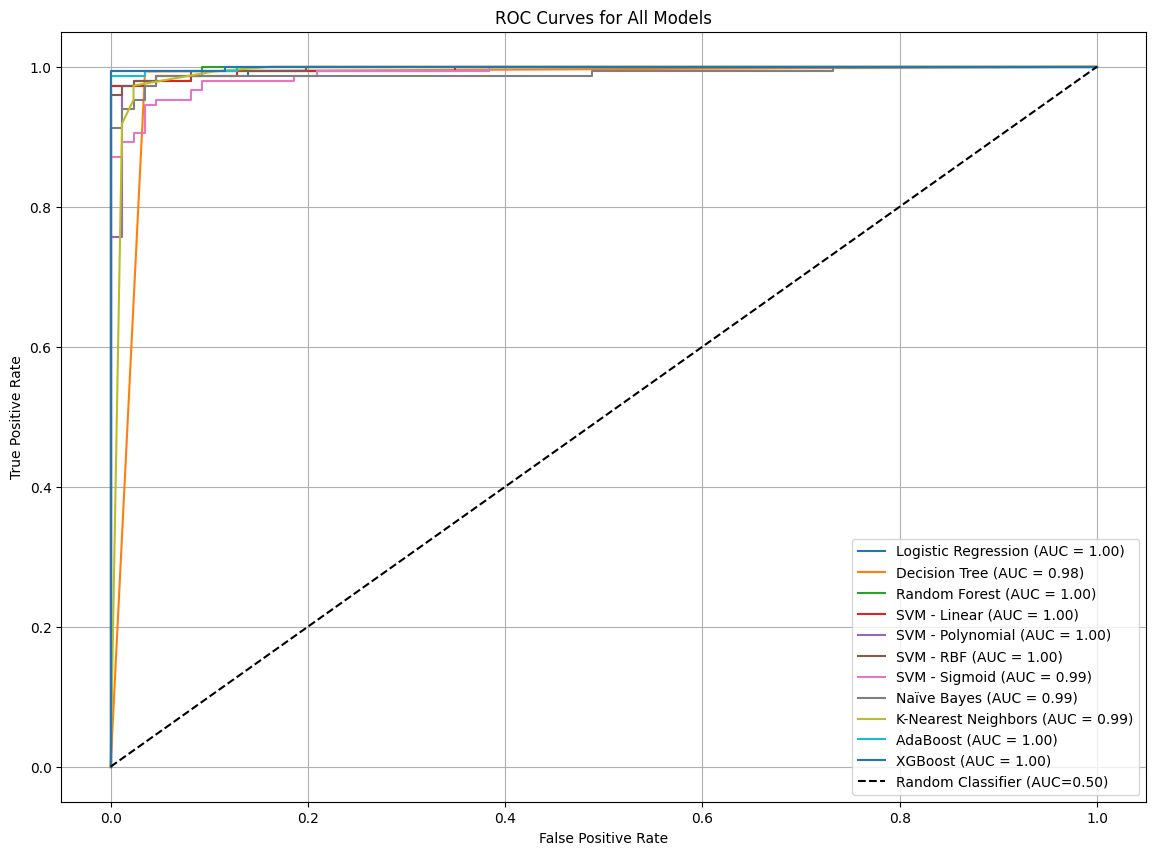

In [47]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "SVM - Linear": SVC(kernel="linear"),
    "SVM - Polynomial": SVC(kernel="poly", degree=3),
    "SVM - RBF": SVC(kernel="rbf"),
    "SVM - Sigmoid": SVC(kernel="sigmoid"),
    "Naïve Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"🔹 {name} Model")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Binarize y_test if it's not already binary (important for ROC)
# Ensure y_train and y_test are properly encoded if needed

plt.figure(figsize=(14, 10))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Check if model has predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = y_pred  # fallback, not ideal for ROC

    # ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_score = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

    print(f"🔹 {name} Model")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

# Plot formatting
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC=0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [48]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

# ---------- 1. Stacking ----------
stack_estimators = [
    ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
    ("svc", SVC(kernel="rbf", probability=True)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
]

stacking = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True         # keep original features alongside meta‑features
)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
print("🔹 Stacking")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))
print("-"*60)

# ---------- 2. Voting – Hard ----------
hard_voting = VotingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("svc", models["SVM - RBF"]),
        ("knn", models["K-Nearest Neighbors"])
    ],
    voting="hard"
)
hard_voting.fit(X_train, y_train)
y_pred_hard = hard_voting.predict(X_test)
print("🔹 Hard Voting")
print("Accuracy:", accuracy_score(y_test, y_pred_hard))
print(classification_report(y_test, y_pred_hard))
print("-"*60)

# ---------- 3. Voting – Soft ----------
soft_voting = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
        ("svc", SVC(kernel="rbf", probability=True)),   # probability=True required
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
    ],
    voting="soft",           # average predicted class‑probabilities
    weights=[2, 1, 2]        # optional: favour stronger base models
)
soft_voting.fit(X_train, y_train)
y_pred_soft = soft_voting.predict(X_test)
print("🔹 Soft Voting")
print("Accuracy:", accuracy_score(y_test, y_pred_soft))
print(classification_report(y_test, y_pred_soft))
print("-"*60)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

🔹 Logistic Regression Model
Average Precision Score: 0.9979
------------------------------------------------------------
🔹 Decision Tree Model
Average Precision Score: 0.9777
------------------------------------------------------------
🔹 Random Forest Model
Average Precision Score: 0.9997
------------------------------------------------------------
🔹 SVM - Linear Model
Average Precision Score: 0.9979
------------------------------------------------------------
🔹 SVM - Polynomial Model
Average Precision Score: 0.9970
------------------------------------------------------------
🔹 SVM - RBF Model
Average Precision Score: 0.9986
------------------------------------------------------------
🔹 SVM - Sigmoid Model
Average Precision Score: 0.9946
------------------------------------------------------------
🔹 Naïve Bayes Model
Average Precision Score: 0.9953
------------------------------------------------------------
🔹 K-Nearest Neighbors Model
Average Precision Score: 0.9908
------------------

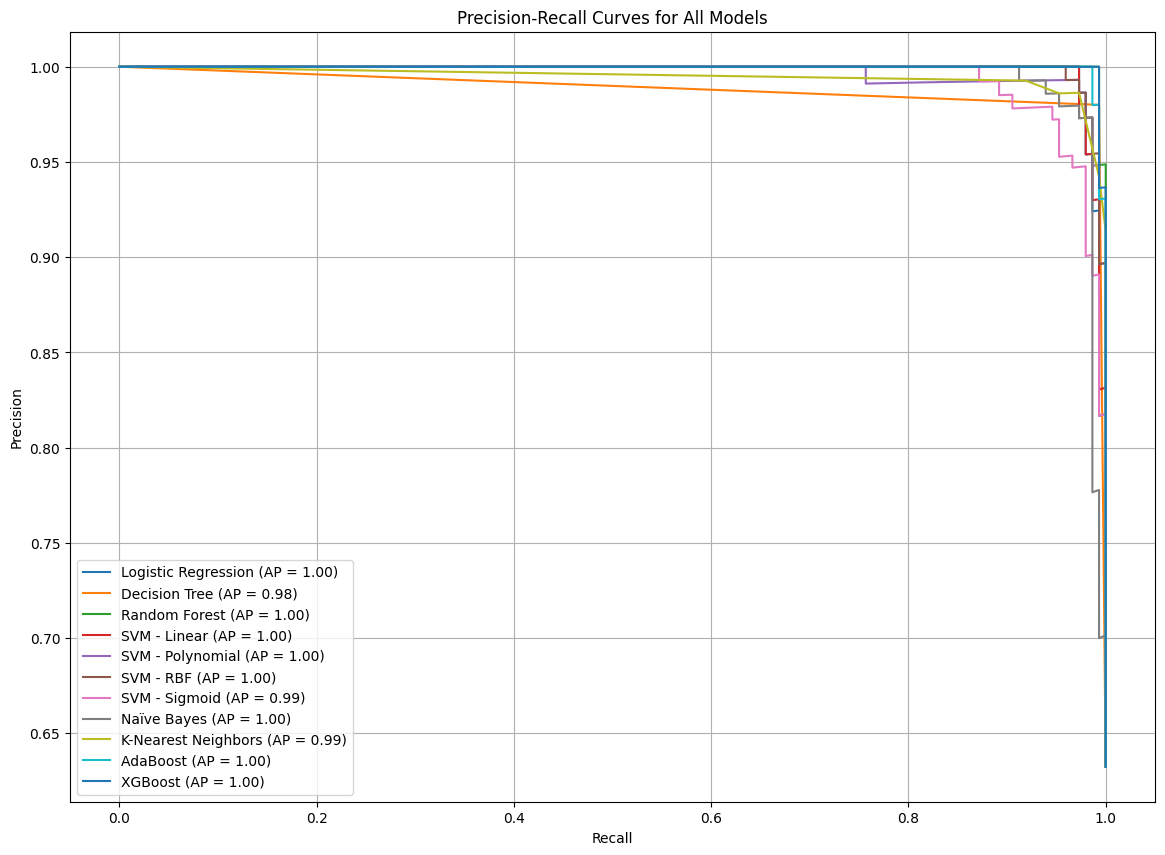

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(14, 10))

for name, model in models.items():
    model.fit(X_train, y_train)

    # Get prediction scores for PR curve
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = y_test  # fallback

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")

    print(f"🔹 {name} Model")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print("-" * 60)

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for All Models")
plt.legend(loc="lower left")
plt.grid()
plt.show()


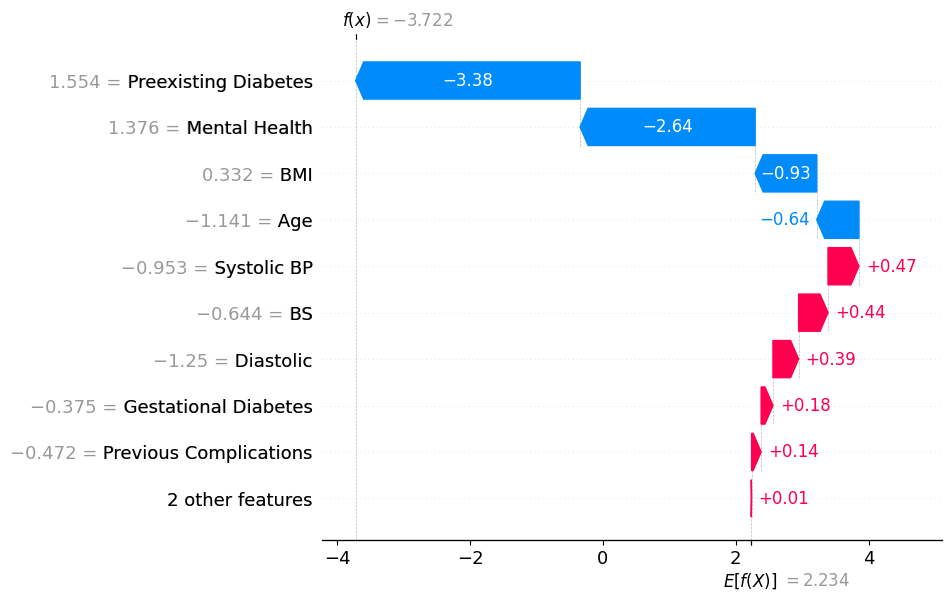

In [ ]:
import shap
import pandas as pd

feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes",
    "Mental Health", "Heart Rate"
]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Choose one tree-based model (like XGBoost)
import shap
from xgboost import XGBClassifier

# Train your model (or reuse existing one)
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Choose an instance
instance_index = 0
instance = X_test.iloc[instance_index]

# Waterfall Plot
shap.plots.waterfall(shap_values[instance_index])

# Force Plot (interactive, best in Jupyter)
shap.plots.force(shap_values[instance_index])



In [ ]:
import shap
from xgboost import XGBClassifier
import pandas as pd

# Feature names
feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes",
    "Mental Health", "Heart Rate", "Risk Level"
]

# Wrap the feature arrays into DataFrames if not already
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Train the model (if not already trained)
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Create the SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Choose a test instance to explain
instance_index = 0  # change index as needed

# Initialize JS for interactive force plot
shap.initjs()

# Display force plot
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[instance_index].values,
    features=X_test.iloc[instance_index],
    feature_names=X_test.columns
)


Feature Importance in Random Forest:
                   Feature  Importance
8     Gestational Diabetes    0.122173
11              Risk Level    0.111347
10              Heart Rate    0.092547
0                      Age    0.091706
6   Previous Complications    0.079841
9            Mental Health    0.079513
4                Body Temp    0.078088
2                Diastolic    0.073980
5                      BMI    0.072393
7     Preexisting Diabetes    0.071491
3                       BS    0.063675
1              Systolic BP    0.063246


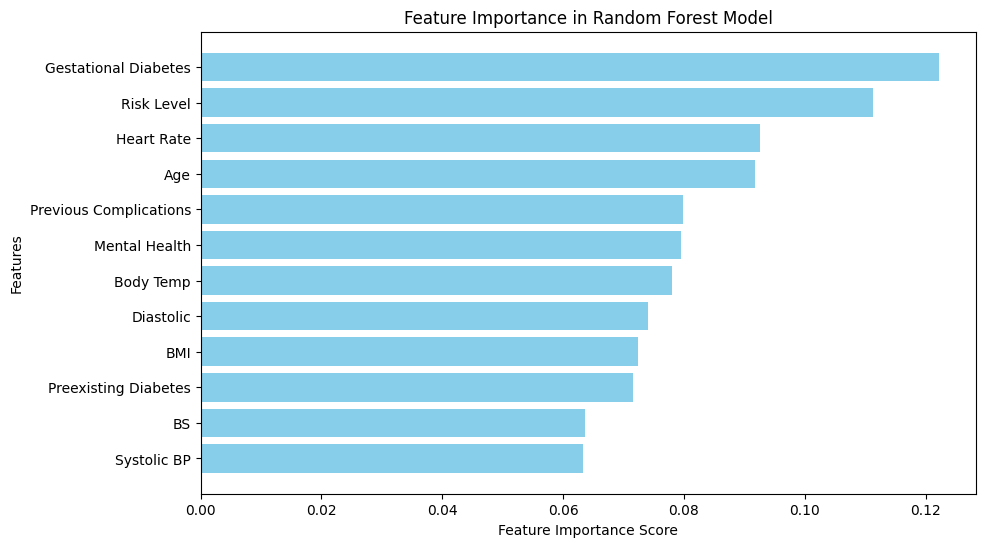

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X_train is a DataFrame
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importance in Random Forest:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define feature names as per the given order
feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI", 
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes", 
    "Mental Health", "Heart Rate", "Risk Level"
]

# Generate synthetic data (replace with actual dataset)
X = np.random.rand(100, len(feature_names))  # 100 samples, 12 features
y = np.random.randint(0, 2, 100)  # Binary classification

# Convert to DataFrame with named columns
X = pd.DataFrame(X, columns=feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train model
models["Random Forest"].fit(X_train, y_train)

# LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=['Low Risk', 'High Risk'],  # Adjust as per your classification
    mode='classification'
)

# Explain a prediction
i = 0  # Choose a test sample index
exp = explainer.explain_instance(X_test.iloc[i], models["Random Forest"].predict_proba)
exp.show_in_notebook()  # For Jupyter Notebook


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, inte

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
# Train EBM model
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# 📌 Local explanation for first 5 test samples
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

# 🌐 Global explanation (overall feature importance & effects)
ebm_global = ebm.explain_global()
show(ebm_global)


<!-- http://127.0.0.1:7001/6072348624/ -->

<!-- http://127.0.0.1:7001/6072993840/ -->

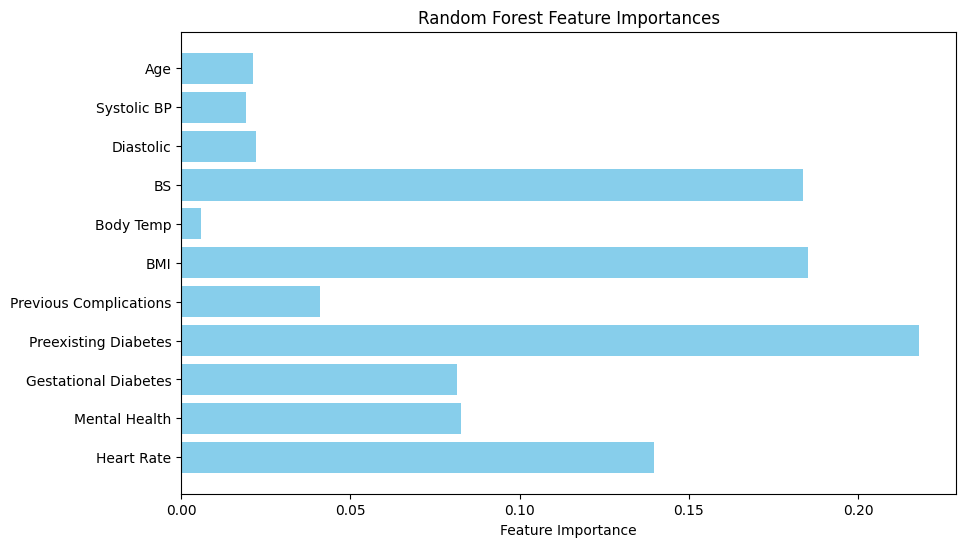

In [96]:
import matplotlib.pyplot as plt

# Example: Feature importance bar plot for Random Forest
rf_model = models["Random Forest"]
if not hasattr(rf_model, "feature_importances_"):
    rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

SHAP Bar Plot for Random Forest


/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/1787853694.py:9: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/plots/_beeswarm.py:718: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/plots/_beeswarm.py:738: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



<Figure size 640x480 with 0 Axes>

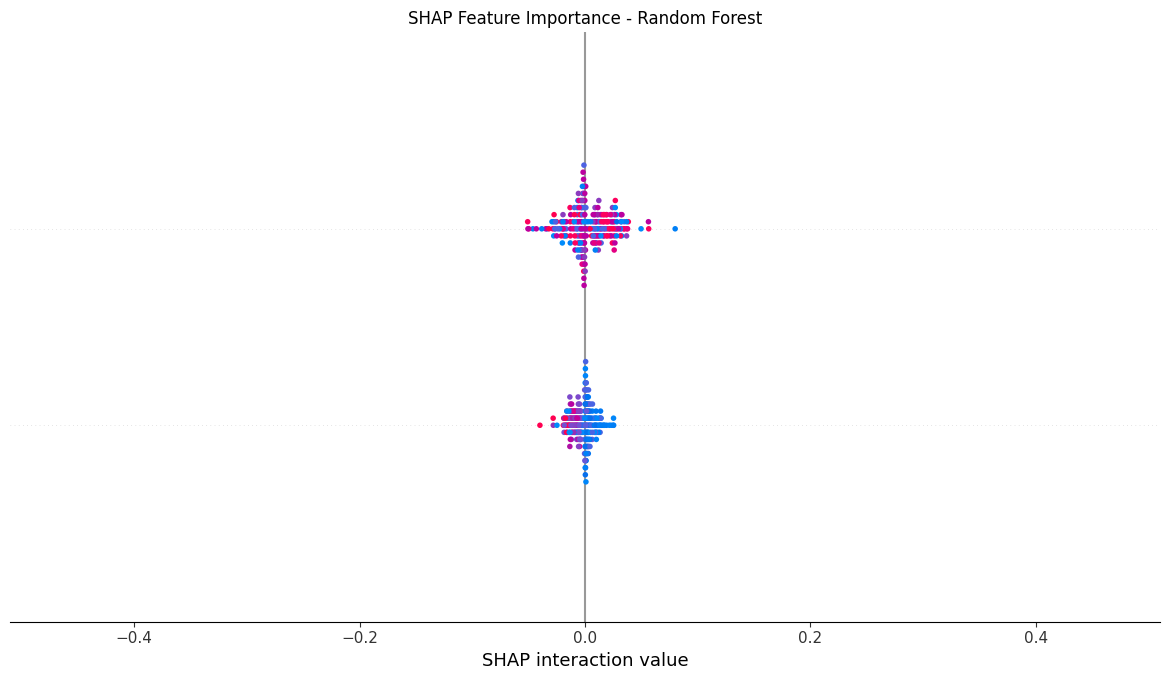

In [104]:
# Random Forest
rf_model = models["Random Forest"]
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)
print("SHAP Bar Plot for Random Forest")
if isinstance(rf_shap_values, list) and len(rf_shap_values) == 2:
    shap.summary_plot(rf_shap_values[1], X_test, plot_type="bar", feature_names=X_test.columns, show=False)
else:
    shap.summary_plot(rf_shap_values, X_test, plot_type="bar", feature_names=X_test.columns, show=False)
plt.title("SHAP Feature Importance - Random Forest")
plt.show()

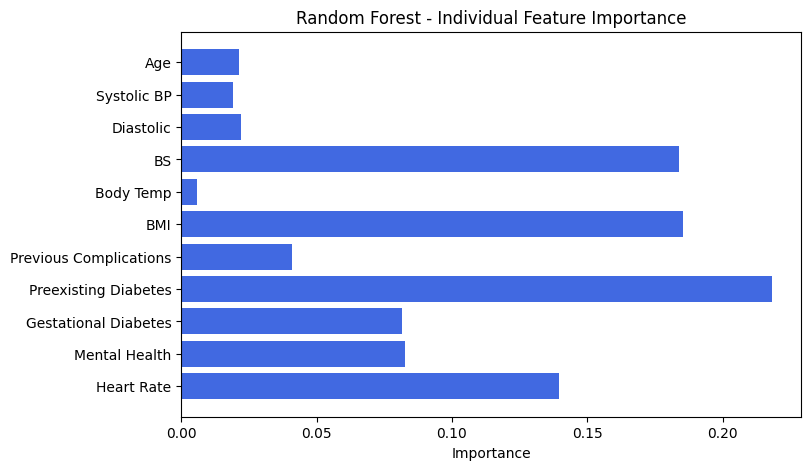

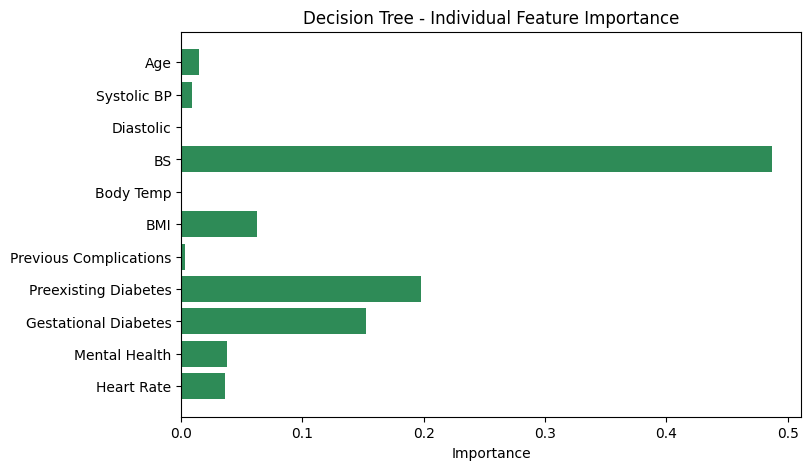

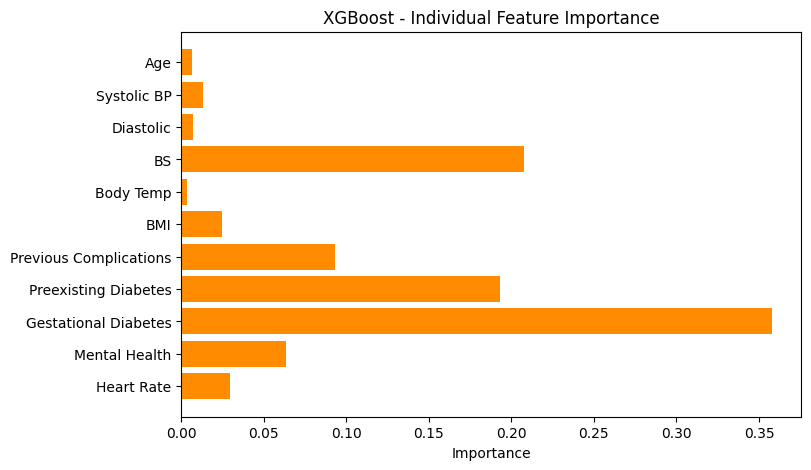

ValueError: x and y must be the same size

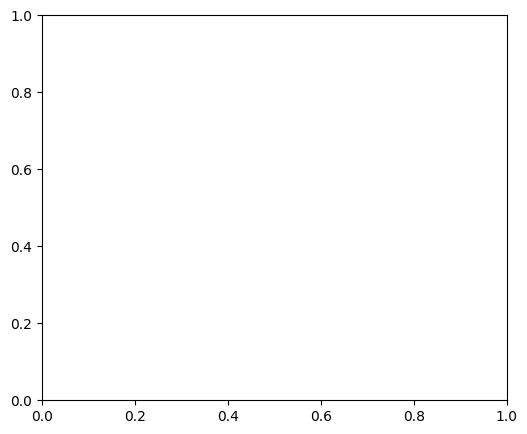

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Random Forest Feature Importance
rf_model = models["Random Forest"]
rf_importances = rf_model.feature_importances_
rf_features = X_test.columns
plt.figure(figsize=(8, 5))
plt.barh(rf_features, rf_importances, color='royalblue')
plt.xlabel("Importance")
plt.title("Random Forest - Individual Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Decision Tree Feature Importance
dt_model = models["Decision Tree"]
dt_importances = dt_model.feature_importances_
dt_features = X_test.columns
plt.figure(figsize=(8, 5))
plt.barh(dt_features, dt_importances, color='seagreen')
plt.xlabel("Importance")
plt.title("Decision Tree - Individual Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# XGBoost Feature Importance
xgb_model = models["XGBoost"]
xgb_importances = xgb_model.feature_importances_
xgb_features = X_test.columns
plt.figure(figsize=(8, 5))
plt.barh(xgb_features, xgb_importances, color='darkorange')
plt.xlabel("Importance")
plt.title("XGBoost - Individual Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [126]:
import shap
import matplotlib.pyplot as plt
import os

# Prepare SHAP explainer and values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

# Create folder to save individual dependence plots
os.makedirs("shap_dependence_plots", exist_ok=True)

class_idx = 0  # choose 0 or 1 depending on which class you want to explain

for col in X_test.columns:
    shap.dependence_plot(col, shap_values.values[:, :, class_idx], X_test, interaction_index=None, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_dependence_plots/{col}_dependence_plot_class{class_idx}.png", dpi=300)
    plt.close()

# Summary plot for the chosen class
shap.summary_plot(shap_values.values[:, :, class_idx], X_test, show=False)
plt.tight_layout()
plt.savefig(f"shap_summary_plot_class{class_idx}.png", dpi=300)
plt.close()

class_idx = 1  # choose 0 or 1 depending on which class you want to explain

for col in X_test.columns:
    shap.dependence_plot(col, shap_values.values[:, :, class_idx], X_test, interaction_index=None, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_dependence_plots/{col}_dependence_plot_class{class_idx}.png", dpi=300)
    plt.close()

# Summary plot for the chosen class
shap.summary_plot(shap_values.values[:, :, class_idx], X_test, show=False)
plt.tight_layout()
plt.savefig(f"shap_summary_plot_class{class_idx}.png", dpi=300)
plt.close()

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/1009034776.py:21: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/1009034776.py:35: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



In [132]:
import shap
import matplotlib.pyplot as plt
import os

def generate_shap_summary_plot(model, X_test, model_name):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)
    os.makedirs(f"shap_dependence_plots_{model_name}", exist_ok=True)

    # If classification and shap_values 3D, else adapt
    if len(shap_values.values.shape) == 3:
        n_classes = shap_values.values.shape[2]
    else:
        n_classes = 1

    for class_idx in range(n_classes):
        shap.summary_plot(
            shap_values.values[:, :, class_idx] if n_classes > 1 else shap_values.values,
            X_test,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"shap_dependence_plots_{model_name}/shap_summary_plot_class{class_idx}.png", dpi=300)
        plt.close()

generate_shap_summary_plot(rf_model, X_test, "random_forest")
generate_shap_summary_plot(xgb_model, X_test, "boost")
generate_shap_summary_plot(dt_model, X_test, "decision_tree")

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/3442076529.py:17: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/3442076529.py:17: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/3442076529.py:17: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/var/folders/w8/n6vtp_314qq3v7l9ntfj3bb00000gn/T/ipykernel_4799/3442076529.p

PermutationExplainer explainer: 101it [00:29,  2.24it/s]                         


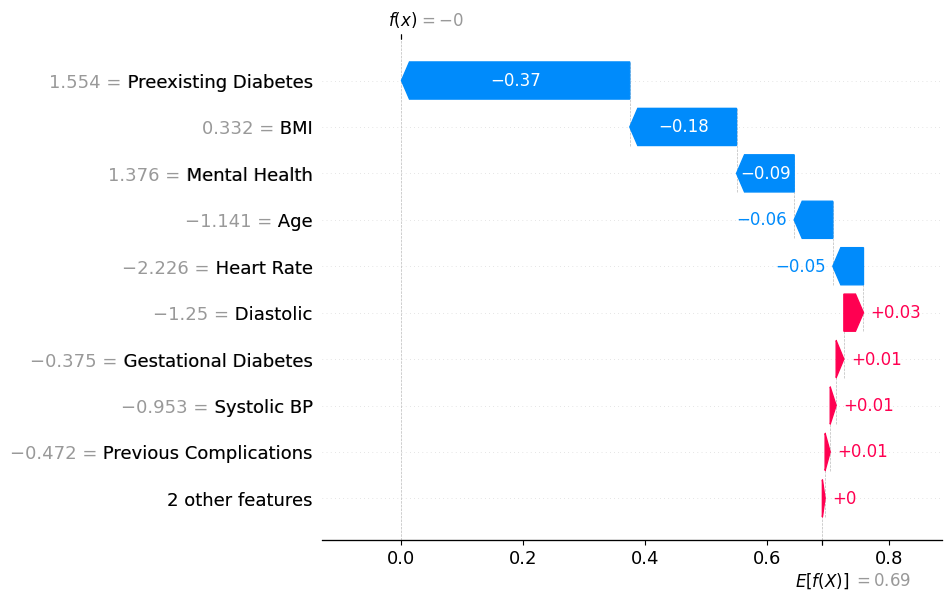

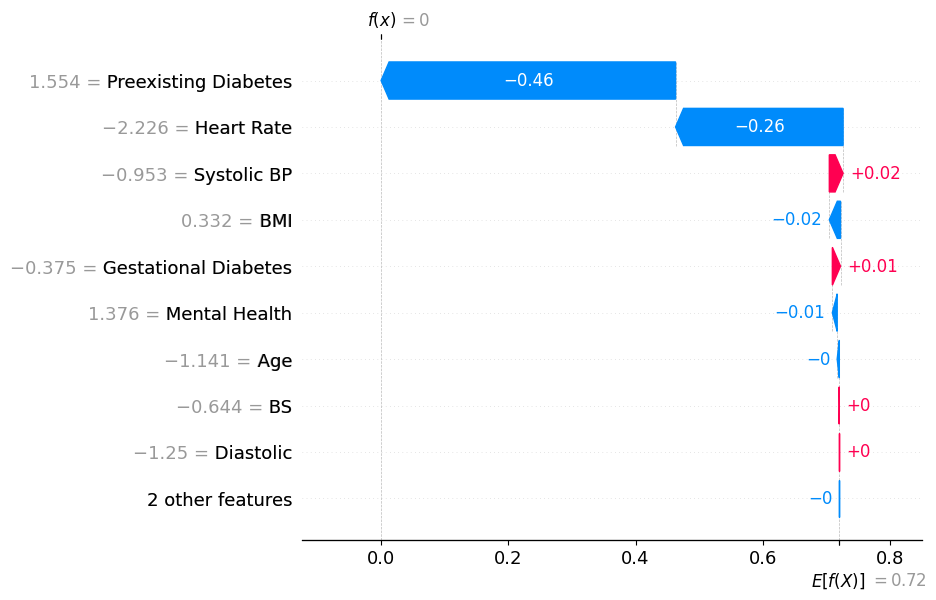

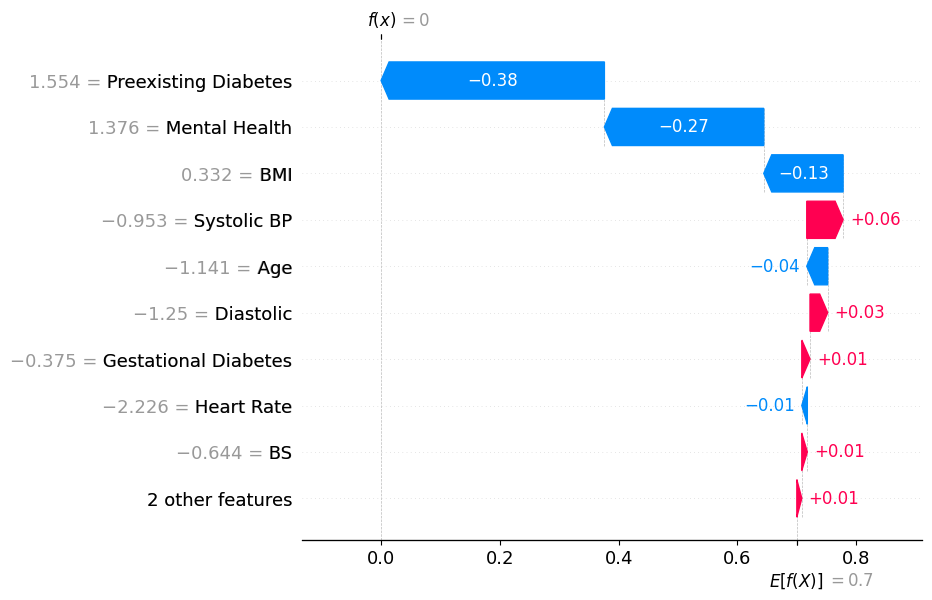

In [140]:
import shap
import matplotlib.pyplot as plt
import os

def generate_shap_dependence_plots(model, X_test, model_name, features=None):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    os.makedirs(f"shap_dependence_plots_{model_name}", exist_ok=True)

    # Choose a subset of features if not specified
    if features is None:
        features = X_test.columns[:10]  # Default: first 10 features

    for feature in features:
        shap.dependence_plot(
            feature,
            shap_values.values if len(shap_values.values.shape) == 2 else shap_values.values[:, :, 0],
            X_test,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"shap_dependence_plots_{model_name}/shap_dependence_{feature}.png", dpi=300)
        plt.close()
generate_shap_dependence_plots(rf_model, X_test, "random_forest")
generate_shap_dependence_plots(rf_model, X_test, "xg boost")
generate_shap_dependence_plots(rf_model, X_test, "decision_tree")
# AdaBoost

explainer = shap.Explainer(models["AdaBoost"].predict, X_test)
shap_values = explainer(X_test[:100])
import matplotlib.pyplot as plt

# Pick one instance (e.g., first row)
idx = 0
shap.plots.waterfall(shap_values[idx])
plt.show()
explainer = shap.Explainer(models["Decision Tree"].predict, X_test)
shap_values = explainer(X_test[:100])
import matplotlib.pyplot as plt

# Pick one instance (e.g., first row)
idx = 0
shap.plots.waterfall(shap_values[idx])
plt.show()
explainer = shap.Explainer(models["XGBoost"].predict, X_test)
shap_values = explainer(X_test[:100])
import matplotlib.pyplot as plt

# Pick one instance (e.g., first row)
idx = 0
shap.plots.waterfall(shap_values[idx])
plt.show()


In [124]:
print(shap_values.values.shape)
print(X_test.shape)


(234, 11, 2)
(234, 11)


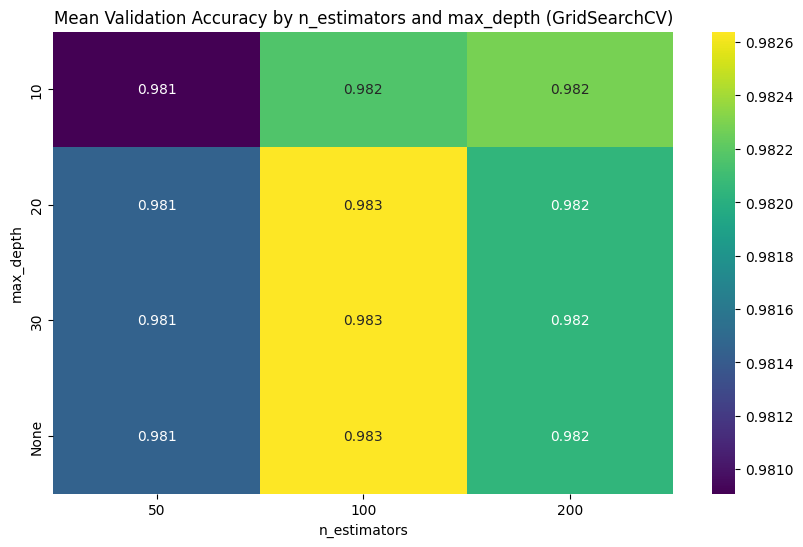

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Replace None in 'param_max_depth' with string 'None' for plotting
results['param_max_depth'] = results['param_max_depth'].astype(str)

# Group by param_max_depth and param_n_estimators and get mean test score (aggregating over other params)
agg_results = results.groupby(['param_max_depth', 'param_n_estimators'])['mean_test_score'].mean().reset_index()

# Sort max_depth for nicer plotting
def sort_key(x):
    return float('inf') if x == 'None' else int(x)

agg_results['param_max_depth'] = pd.Categorical(agg_results['param_max_depth'],
                                               categories=sorted(agg_results['param_max_depth'].unique(), key=sort_key),
                                               ordered=True)

# Pivot table
pivot_table = agg_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title("Mean Validation Accuracy by n_estimators and max_depth (GridSearchCV)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()


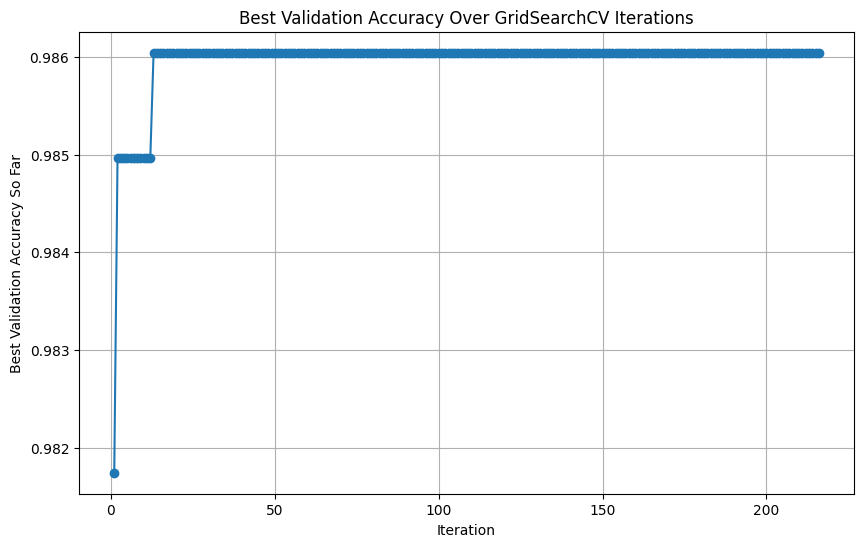

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract cv_results_
results = pd.DataFrame(grid_search.cv_results_)

# Sort results by the order GridSearchCV tested (cv_results_ are in order of parameter combinations)
# We can use the index as iteration number
results = results.reset_index()

# Track best score so far for each iteration
best_scores = results['mean_test_score'].cummax()

plt.figure(figsize=(10, 6))
plt.plot(results['index'] + 1, best_scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Validation Accuracy So Far")
plt.title("Best Validation Accuracy Over GridSearchCV Iterations")
plt.grid(True)
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=9, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=124; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=124; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=124; total time=   0.7s
[CV] EN

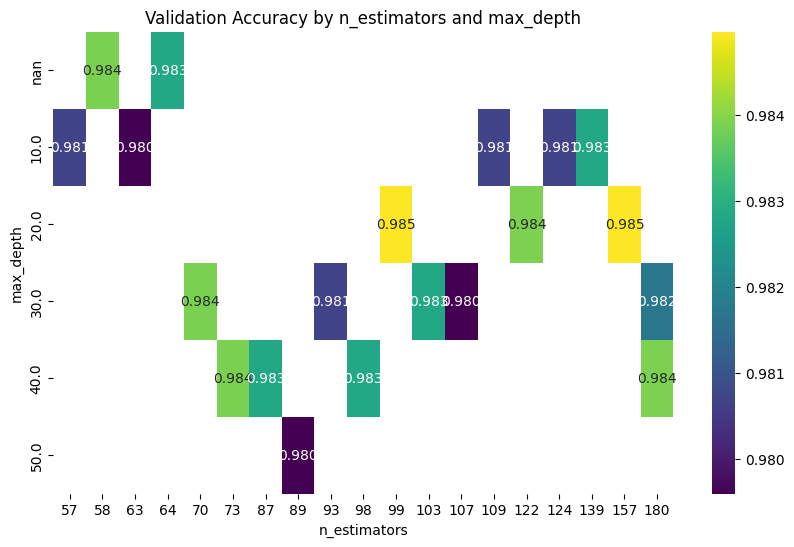

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter distributions for random sampling
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,            # Number of parameter settings sampled
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit on training data
random_search.fit(X_train, y_train)

print("Best Hyperparameters from Randomized Search:", random_search.best_params_)

# Predict and evaluate
best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)

print("Accuracy on test data:", accuracy_score(y_test, y_pred_random))
print(classification_report(y_test, y_pred_random))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract results into DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Focus on mean test scores, n_estimators and max_depth parameters
results_filtered = results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]

# Pivot table to create matrix for heatmap
pivot_table = results_filtered.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# Plot heatmap of accuracy for different combinations
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title("Validation Accuracy by n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()



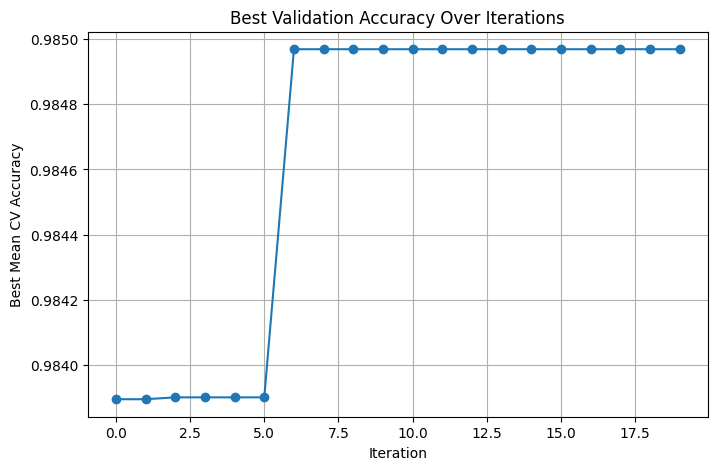

In [79]:
best_scores = []
for i in range(len(results)):
    best_scores.append(results['mean_test_score'][:i+1].max())

plt.figure(figsize=(8, 5))
plt.plot(best_scores, marker='o')
plt.title("Best Validation Accuracy Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Mean CV Accuracy")
plt.grid(True)
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=5, min_samples_split=5, n_estimators=151; total time=   0.2s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=5, min_samples_split=5, n_estimators=151; total time=   0.2s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=5, min_samples_split=5, n_estimators=151; total time=   0.2s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=5, min_samples_split=5, n_estimators=151; total time=   0.2s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=5, min_samples_split=5, n_estimators=151; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.2s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.2s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=2,

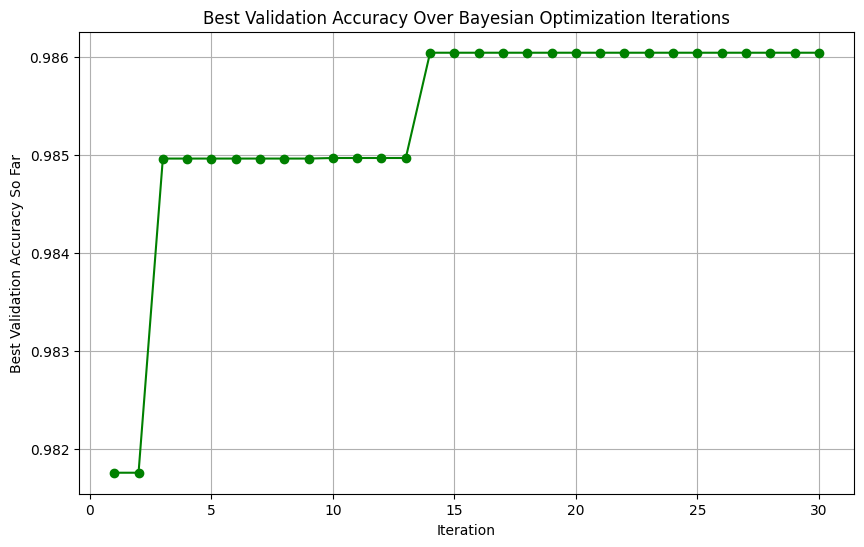

In [86]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter search space
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'bootstrap': Categorical([True, False])
}

# Setup Bayesian optimization search
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=30,          # Number of parameter settings evaluated
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42,
    verbose=2
)

# Fit on training data
bayes_search.fit(X_train, y_train)

print("Best Hyperparameters from Bayesian Optimization:", bayes_search.best_params_)

# Predict and evaluate
best_rf_bayes = bayes_search.best_estimator_
y_pred_bayes = best_rf_bayes.predict(X_test)

print("Accuracy on test data:", accuracy_score(y_test, y_pred_bayes))
print(classification_report(y_test, y_pred_bayes))
results = pd.DataFrame(bayes_search.cv_results_)
results = results.reset_index()

best_scores = results['mean_test_score'].cummax()

plt.figure(figsize=(10, 6))
plt.plot(results['index'] + 1, best_scores, marker='o', color='green')
plt.xlabel("Iteration")
plt.ylabel("Best Validation Accuracy So Far")
plt.title("Best Validation Accuracy Over Bayesian Optimization Iterations")
plt.grid(True)
plt.show()



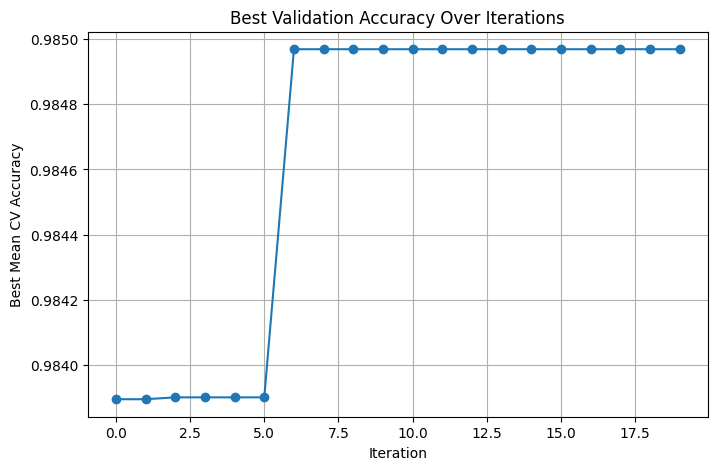

In [80]:
best_scores = []
for i in range(len(results)):
    best_scores.append(results['mean_test_score'][:i+1].max())

plt.figure(figsize=(8, 5))
plt.plot(best_scores, marker='o')
plt.title("Best Validation Accuracy Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Mean CV Accuracy")
plt.grid(True)
plt.show()
